<a href="https://colab.research.google.com/github/LeoMx11/Skin-Cancer-Classification/blob/main/Skin_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer Classification Project

Using kaggle dataset with malignant/benign skin cancers and sorting into each.

## Model 1: Full Batch Gradient Descent

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

print("Path to dataset files:", path)

100%|██████████| 325M/325M [00:09<00:00, 34.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


In [2]:
import os
from PIL import Image
import torch
import numpy as np
from torch import nn

In [3]:
def getImageTensor(path):
    image = np.asarray(Image.open(path).convert('RGB'))
    image_tensor = torch.tensor(image)
    return image_tensor

In [4]:
benign_train = []
benign_test = []
malignant_train = []
malignant_test = []

for file in os.listdir(path + '/data/train/benign'):
    benign_train.append(getImageTensor(path + '/data/train/benign/' + file))

for file in os.listdir(path + '/data/train/malignant'):
    malignant_train.append(getImageTensor(path + '/data/train/malignant/' + file))

for file in os.listdir(path + '/data/test/benign'):
    benign_test.append(getImageTensor(path + '/data/test/benign/' + file))

for file in os.listdir(path + '/data/test/malignant'):
    malignant_test.append(getImageTensor(path + '/data/test/malignant/' + file))


In [5]:
benign_test = torch.stack(benign_test)
benign_train = torch.stack(benign_train)
malignant_test = torch.stack(malignant_test)
malignant_train = torch.stack(malignant_train)

In [6]:
benign_test.shape, benign_train.shape, malignant_test.shape, malignant_train.shape

(torch.Size([360, 224, 224, 3]),
 torch.Size([1440, 224, 224, 3]),
 torch.Size([300, 224, 224, 3]),
 torch.Size([1197, 224, 224, 3]))

In [7]:
y_benign_test = np.zeros(len(benign_test))
y_benign_train = np.zeros(len(benign_train))
y_malignant_test = np.ones(len(malignant_test))
y_malignant_train = np.ones(len(malignant_train))

In [8]:
X_train = torch.cat((benign_train, malignant_train))
X_test = torch.cat((benign_test, malignant_test))

y_train = torch.tensor(np.concatenate((y_benign_train, y_malignant_train)))
y_test = torch.tensor(np.concatenate((y_benign_test, y_malignant_test)))

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2637, 224, 224, 3]),
 torch.Size([660, 224, 224, 3]),
 torch.Size([2637]),
 torch.Size([660]))

In [10]:
X_train = X_train.transpose(1, 3)
X_test = X_test.transpose(1, 3)

In [11]:
from torch.utils.data import dataloader
import matplotlib.pyplot as plt

In [12]:
class SkinCancerClassifierV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_stack = nn.Sequential(
      nn.Conv2d(3, 1, 3, stride = 2),
      nn.MaxPool2d(2,2),
      nn.Flatten(),
      nn.Linear(3025, 10),
      nn.Linear(10, 1)
      )

  def forward(self, x):
    return self.layer_stack(x)



In [13]:
my_model = SkinCancerClassifierV1()
my_model.state_dict()

OrderedDict([('layer_stack.0.weight',
              tensor([[[[-0.1308,  0.1187,  0.0741],
                        [ 0.1466, -0.0042, -0.1646],
                        [-0.1413, -0.0313,  0.1211]],
              
                       [[-0.1783, -0.0490,  0.1302],
                        [-0.0223, -0.1744, -0.0406],
                        [-0.1131, -0.1457, -0.0160]],
              
                       [[-0.1762,  0.0026, -0.1653],
                        [-0.0150, -0.1158, -0.1633],
                        [-0.1485, -0.1132,  0.1089]]]])),
             ('layer_stack.0.bias', tensor([0.0356])),
             ('layer_stack.3.weight',
              tensor([[ 4.2196e-03,  5.8120e-03,  4.2509e-04,  ..., -3.9604e-03,
                       -1.1114e-02,  1.5502e-02],
                      [ 1.0918e-02, -5.6882e-05,  2.3318e-03,  ...,  5.5355e-03,
                       -2.7814e-03, -7.9780e-03],
                      [-1.5117e-02, -1.3836e-02,  1.4386e-02,  ...,  1.2245e-02,
            

In [14]:
optimizer = torch.optim.Adam(my_model.parameters(), lr = 0.005)
loss_fn = nn.BCEWithLogitsLoss()

In [15]:
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

Epoch: 0 | Loss: 8.48670 | Acc: 44.07% | Test Loss: 1416.623046875 | Test Accuracy: 54.55%
Epoch: 1 | Loss: 1409.97620 | Acc: 54.61% | Test Loss: 1305.755126953125 | Test Accuracy: 54.55%
Epoch: 2 | Loss: 1298.81531 | Acc: 54.61% | Test Loss: 812.1287841796875 | Test Accuracy: 54.55%
Epoch: 3 | Loss: 807.24811 | Acc: 54.61% | Test Loss: 284.23834228515625 | Test Accuracy: 54.55%
Epoch: 4 | Loss: 282.38907 | Acc: 54.61% | Test Loss: 178.09066772460938 | Test Accuracy: 45.45%
Epoch: 5 | Loss: 175.90334 | Acc: 45.39% | Test Loss: 339.6568603515625 | Test Accuracy: 45.45%
Epoch: 6 | Loss: 334.30997 | Acc: 45.39% | Test Loss: 323.46051025390625 | Test Accuracy: 45.45%
Epoch: 7 | Loss: 316.94278 | Acc: 45.39% | Test Loss: 230.81263732910156 | Test Accuracy: 45.15%
Epoch: 8 | Loss: 224.36626 | Acc: 45.24% | Test Loss: 123.104248046875 | Test Accuracy: 47.12%
Epoch: 9 | Loss: 117.25128 | Acc: 46.30% | Test Loss: 44.14385986328125 | Test Accuracy: 61.97%
Epoch: 10 | Loss: 40.53534 | Acc: 61.24%

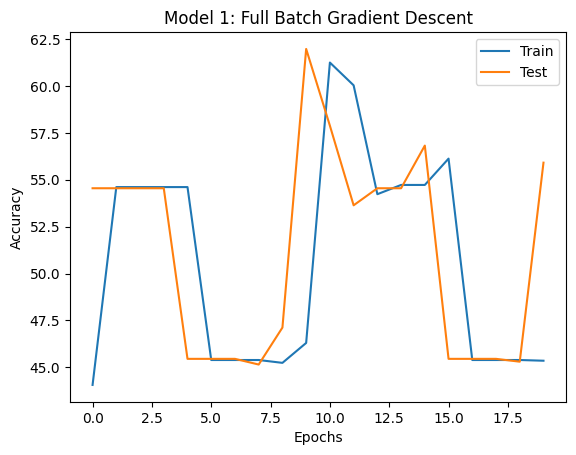

In [16]:
train_acc_list = []
test_acc_list = []

epochs = 20

for epoch in range(epochs):

  my_model.train()

  y_logits = my_model(X_train.float()).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train.float())
  acc = accuracy(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  my_model.eval()
  with torch.inference_mode():
    test_logits = my_model(X_test.float()).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test.float())
    test_acc = accuracy(y_test, test_pred)

  if epoch % 1 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:} | Test Accuracy: {test_acc:.2f}%")

  train_acc_list.append(acc)
  test_acc_list.append(test_acc)

epoch = list(range(epochs))

plt.plot(epoch, train_acc_list, label = 'Train')
plt.plot(epoch, test_acc_list, label = 'Test')
plt.title('Model 1: Full Batch Gradient Descent')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Model 2: Mini-Batch Gradient Descent

In [17]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)

In [24]:
mini_train_dataloader = dataloader.DataLoader(train, batch_size = 32, shuffle = True)
mini_test_dataloader = dataloader.DataLoader(test, batch_size = 32, shuffle = True)

full_train_dataloader = dataloader.DataLoader(train, batch_size = len(train), shuffle = True)
full_test_dataloader = dataloader.DataLoader(test, batch_size = len(test), shuffle = True)

In [19]:
class SkinCancerClassifierV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_stack = nn.Sequential(
      nn.Conv2d(3, 4, 3, stride = 2),
      nn.MaxPool2d(2,2),
      nn.Conv2d(4, 4, 3, stride = 1),
      nn.Conv2d(4, 4, 3, stride = 2),
      nn.MaxPool2d(2,2),
      nn.Conv2d(4,4,3,stride = 2),
      nn.Flatten(),
      nn.Linear(144, 8),
      nn.Linear(8, 1)
      )

  def forward(self, x):
    return self.layer_stack(x)


Epoch: 0 | Loss: 52.42759 | Acc: 65.84% | Test Loss: 12.12245 | Test Accuracy: 68.57%
Epoch: 1 | Loss: 48.18645 | Acc: 69.40% | Test Loss: 11.65560 | Test Accuracy: 75.30%
Epoch: 2 | Loss: 41.72199 | Acc: 75.44% | Test Loss: 9.45572 | Test Accuracy: 74.91%
Epoch: 3 | Loss: 37.76088 | Acc: 78.01% | Test Loss: 9.44416 | Test Accuracy: 80.57%
Epoch: 4 | Loss: 35.24644 | Acc: 80.52% | Test Loss: 8.75204 | Test Accuracy: 78.10%
Epoch: 5 | Loss: 33.35454 | Acc: 81.53% | Test Loss: 8.41403 | Test Accuracy: 82.32%
Epoch: 6 | Loss: 33.19926 | Acc: 81.63% | Test Loss: 8.46801 | Test Accuracy: 79.58%
Epoch: 7 | Loss: 31.05557 | Acc: 82.96% | Test Loss: 12.01788 | Test Accuracy: 70.21%
Epoch: 8 | Loss: 33.52917 | Acc: 81.95% | Test Loss: 8.64033 | Test Accuracy: 81.04%
Epoch: 9 | Loss: 31.02122 | Acc: 82.80% | Test Loss: 9.04043 | Test Accuracy: 80.80%
Epoch: 10 | Loss: 33.31040 | Acc: 81.42% | Test Loss: 10.43604 | Test Accuracy: 78.48%
Epoch: 11 | Loss: 30.48669 | Acc: 83.38% | Test Loss: 9.6657

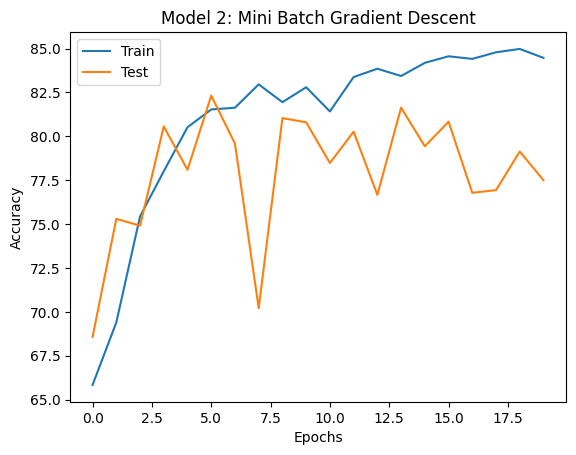

In [26]:
my_model2 = SkinCancerClassifierV2()
optimizer = torch.optim.Adam(my_model2.parameters(), lr = 0.002)
loss_fn = nn.BCEWithLogitsLoss()

train_acc_list = []
test_acc_list = []

epochs = 20

for epoch in range(epochs):

  train_loss = 0
  train_acc = 0

  for X_train, y_train in mini_train_dataloader:
    my_model2.train()

    y_logits = my_model2(X_train.float()).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    train_loss += loss
    acc = accuracy(y_train, y_pred)
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_acc /= len(mini_train_dataloader)
  train_acc_list.append(train_acc)

  ttl_test_loss = 0
  ttl_test_acc = 0

  my_model2.eval()
  with torch.inference_mode():
    for X_test, y_test in mini_test_dataloader:

      test_logits = my_model2(X_test.float()).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      test_loss = loss_fn(test_logits, y_test.float())
      ttl_test_loss += test_loss
      test_acc = accuracy(y_test, test_pred)
      ttl_test_acc += test_acc

  ttl_test_acc /= len(mini_test_dataloader)

  test_acc_list.append(ttl_test_acc)

  if epoch % 1 == 0:
    print(f"Epoch: {epoch} | Loss: {train_loss:.5f} | Acc: {train_acc:.2f}% | Test Loss: {ttl_test_loss:.5f} | Test Accuracy: {ttl_test_acc:.2f}%")

epoch = list(range(epochs))

plt.plot(epoch, train_acc_list, label = 'Train')
plt.plot(epoch, test_acc_list, label = 'Test')
plt.title('Model 2: Mini Batch Gradient Descent')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Learning Rate Analysis

Now, with both models I will test different learning rates and plot them against the average test loss of the last half of the epochs. In this way, we will find the optimal learning rate for each model.


-----Learning Rate: 0.004-----

***FULL BATCH MODEL***
Epoch: 0 | Loss: 5.55717 | Acc: 45.39% | Test Loss: 187.66800 | Test Accuracy: 54.55%
***MINI BATCH MODEL***
Epoch: 0 | Loss: 54.47114 | Acc: 63.18% | Test Loss: 11.56708 | Test Accuracy: 66.16%
***FULL BATCH MODEL***
Epoch: 1 | Loss: 189.08691 | Acc: 54.61% | Test Loss: 105.17587 | Test Accuracy: 54.55%
***MINI BATCH MODEL***
Epoch: 1 | Loss: 46.45760 | Acc: 70.17% | Test Loss: 10.11388 | Test Accuracy: 74.17%
***FULL BATCH MODEL***
Epoch: 2 | Loss: 107.09064 | Acc: 54.68% | Test Loss: 66.58167 | Test Accuracy: 45.61%
***MINI BATCH MODEL***
Epoch: 2 | Loss: 37.71436 | Acc: 79.07% | Test Loss: 8.86912 | Test Accuracy: 76.64%
***FULL BATCH MODEL***
Epoch: 3 | Loss: 62.07061 | Acc: 45.62% | Test Loss: 93.76270 | Test Accuracy: 43.94%
***MINI BATCH MODEL***
Epoch: 3 | Loss: 37.68280 | Acc: 78.95% | Test Loss: 11.49636 | Test Accuracy: 71.61%
***FULL BATCH MODEL***
Epoch: 4 | Loss: 88.77428 | Acc: 44.18% | Test Loss: 38.01868 | Test A

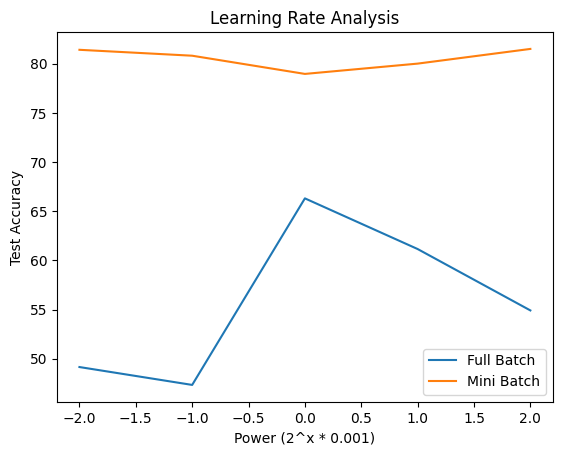

In [47]:
epochs = 10

full_acc_data = []
mini_acc_data = []
power_data = []

for i in range(2,-3,-1):

  fullBatchModel = SkinCancerClassifierV1()
  miniBatchModel = SkinCancerClassifierV2()

  learn = (2**i) * 0.001

  print(f"\n-----Learning Rate: {learn}-----\n")

  optimizer1 = torch.optim.Adam(fullBatchModel.parameters(), lr = learn)
  optimizer2 = torch.optim.Adam(miniBatchModel.parameters(), lr = learn)
  loss_func = torch.nn.BCEWithLogitsLoss()

  full_test_accs = 0
  mini_test_accs = 0

  for epoch in range(epochs):

    ## FULL BATCH MODEL

    print("***FULL BATCH MODEL***")

    for X_train, y_train in full_train_dataloader:

      fullBatchModel.train()

      y_logits = fullBatchModel(X_train.float()).squeeze()
      y_pred = torch.round(torch.sigmoid(y_logits))

      loss = loss_fn(y_logits, y_train.float())
      acc = accuracy(y_train, y_pred)

      optimizer1.zero_grad()
      loss.backward()
      optimizer1.step()

    ttl_test_acc = 0
    ttl_test_loss = 0

    fullBatchModel.eval()
    with torch.inference_mode():
      for X_test, y_test in full_test_dataloader:
        test_logits = fullBatchModel(X_test.float()).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test.float())
        ttl_test_loss += test_loss
        test_acc = accuracy(y_test, test_pred)
        ttl_test_acc += test_acc

    ttl_test_acc /= len(full_test_dataloader)

    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {ttl_test_loss:.5f} | Test Accuracy: {ttl_test_acc:.2f}%")

    if epoch >= epochs / 2:
      full_test_accs += test_acc

    ## MINI BATCH MODEL

    print("***MINI BATCH MODEL***")

    mini_train_loss = 0
    mini_train_acc = 0

    for mini_X_train, mini_y_train in mini_train_dataloader:
      miniBatchModel.train()

      mini_y_logits = miniBatchModel(mini_X_train.float()).squeeze()
      mini_y_pred = torch.round(torch.sigmoid(mini_y_logits))

      mini_loss = loss_fn(mini_y_logits, mini_y_train)
      mini_train_loss += mini_loss
      mini_acc = accuracy(mini_y_train, mini_y_pred)
      mini_train_acc += mini_acc

      optimizer2.zero_grad()
      mini_loss.backward()
      optimizer2.step()

    mini_train_acc /= len(mini_train_dataloader)
    train_acc_list.append(mini_train_acc)

    mini_ttl_test_loss = 0
    mini_ttl_test_acc = 0

    miniBatchModel.eval()
    with torch.inference_mode():
      for mini_X_test, mini_y_test in mini_test_dataloader:

        mini_test_logits = miniBatchModel(mini_X_test.float()).squeeze()
        mini_test_pred = torch.round(torch.sigmoid(mini_test_logits))
        mini_test_loss = loss_fn(mini_test_logits, mini_y_test.float())
        mini_ttl_test_loss += mini_test_loss
        mini_test_acc = accuracy(mini_y_test, mini_test_pred)
        mini_ttl_test_acc += mini_test_acc

    mini_ttl_test_acc /= len(mini_test_dataloader)

    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {mini_train_loss:.5f} | Acc: {mini_train_acc:.2f}% | Test Loss: {mini_ttl_test_loss:.5f} | Test Accuracy: {mini_ttl_test_acc:.2f}%")


    if epoch >= epochs / 2:
      mini_test_accs += mini_ttl_test_acc

  full_acc_data.append(full_test_accs / (epochs / 2))
  mini_acc_data.append(mini_test_accs / (epochs / 2))
  power_data.append(i)

plt.plot(power_data, full_acc_data, label = 'Full Batch')
plt.plot(power_data, mini_acc_data, label = 'Mini Batch')
plt.title('Learning Rate Analysis')
plt.xlabel('Power (2^x * 0.001)')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()



As we would expect, the mini batch model functions best with a slightly higher learning rate (in this case 0.004 was the best) since it is updating its parameters more times, so it has more chances to get to its ideal zone. The full batch model seemed to be basically randomly guessing, but did have a strong showing at lr = 0.001.

Let's see the models in practice:

Text(0.5, 1.0, 'Batch predicts: Malignant')

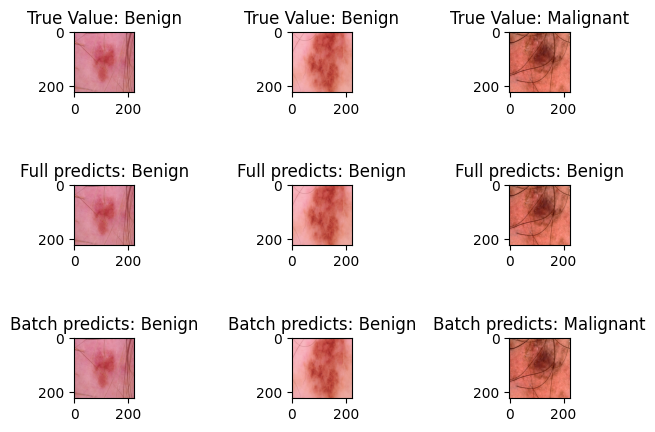

In [61]:
plt.subplot(5,7,1)
plt.imshow(np.array(X_test[0].transpose(0,2)))
plt.title("True Value: Benign" if y_test[0] == 0 else "True Value: Malignant")

plt.subplot(5,7,15)
plt.imshow(X_test[0].transpose(0,2))
plt.title("Full predicts: Benign" if torch.round(torch.sigmoid(my_model(X_test[0].float()).squeeze())) == 0 else "Full predicts: Malignant")

plt.subplot(5,7,29),
plt.imshow(X_test[0].transpose(0,2))
plt.title("Batch predicts: Benign" if torch.round(torch.sigmoid(my_model2(X_test.float()).squeeze()))[0] == 0 else "Batch predicts: Malignant")



plt.subplot(5,7,4)
plt.imshow(np.array(X_test[1].transpose(0,2)))
plt.title("True Value: Benign" if y_test[1] == 0 else "True Value: Malignant")

plt.subplot(5,7,18)
plt.imshow(X_test[1].transpose(0,2))
plt.title("Full predicts: Benign" if torch.round(torch.sigmoid(my_model(X_test[1].float()).squeeze())) == 0 else "Full predicts: Malignant")

plt.subplot(5,7,32),
plt.imshow(X_test[1].transpose(0,2))
plt.title("Batch predicts: Benign" if torch.round(torch.sigmoid(my_model2(X_test.float()).squeeze()))[1] == 0 else "Batch predicts: Malignant")



plt.subplot(5,7,7)
plt.imshow(np.array(X_test[2].transpose(0,2)))
plt.title("True Value: Benign" if y_test[2] == 0 else "True Value: Malignant")

plt.subplot(5,7,21)
plt.imshow(X_test[2].transpose(0,2))
plt.title("Full predicts: Benign" if torch.round(torch.sigmoid(my_model(X_test[2].float()).squeeze())) == 0 else "Full predicts: Malignant")

plt.subplot(5,7,35)
plt.imshow(X_test[2].transpose(0,2))
plt.title("Batch predicts: Benign" if torch.round(torch.sigmoid(my_model2(X_test.float()).squeeze()))[2] == 0 else "Batch predicts: Malignant")

As we can see, the Batch model definitely has better accurancy and should be the type of model used for this problem.